In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [81]:
dataset_filepath = '../../data/dfl-bundesliga-data-shootout'
train = pd.read_csv(os.path.join(dataset_filepath, 'train.csv'))

In [68]:
train.head(3)

video_id        time      event        event_attributes
0  1606b0e6_0  200.265822      start                     NaN
1  1606b0e6_0  201.150000  challenge  ['ball_action_forced']
2  1606b0e6_0  202.765822        end                     NaN

In [57]:
train['event_id'] = train.index // 3

In [58]:
# bring start and end times of each event onto the same row
train.groupby(['event_id','event'])['time'].mean().unstack()

event     challenge          end      play        start   throwin
event_id                                                         
0           201.150   202.765822       NaN   200.265822       NaN
1           210.870   212.624111       NaN   210.124111       NaN
2               NaN   220.350213       NaN   217.850213   219.230
3               NaN   226.430850   224.430   223.930850       NaN
4               NaN   231.455367   229.390   228.955367       NaN
...             ...          ...       ...          ...       ...
3735            NaN  3043.126523  3041.347  3040.626523       NaN
3736            NaN          NaN  3051.707  3049.497881       NaN
3737       3056.587  3053.744023       NaN  3055.572895       NaN
3738            NaN  3058.072895       NaN  3068.280519  3069.547
3739            NaN  3070.780519       NaN          NaN       NaN

[3740 rows x 5 columns]

In [62]:
fps = 25
train['frame'] = train['time'] * fps
train['frame_rounded'] = train['frame'].round().astype(int)

In [97]:
video_id = '1606b0e6_0'
video_path = 'train/' + video_id + '.mp4'
full_video_path = os.path.join(dataset_filepath, video_path)

cap = cv2.VideoCapture(full_video_path)
ret, img = cap.read()
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
cap.release()

# Only concerned with video 1606b0e6_0
train = train[train.video_id == video_id]

train['frame'] = train['time'] * fps
train['frame_rounded'] = train['frame'].round().astype(int)
train.head(5)

video_id        time      event           event_attributes        frame  \
0  1606b0e6_0  200.265822      start                        NaN  5006.645548   
1  1606b0e6_0  201.150000  challenge     ['ball_action_forced']  5028.750000   
2  1606b0e6_0  202.765822        end                        NaN  5069.145548   
3  1606b0e6_0  210.124111      start                        NaN  5253.102780   
4  1606b0e6_0  210.870000  challenge  ['opponent_dispossessed']  5271.750000   

   frame_rounded  
0           5007  
1           5029  
2           5069  
3           5253  
4           5272

In [99]:
# Annotation from Gaussian distribution (sigma = 20 frames)
# Inspiration from: https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout/discussion/360331

# Initialise labels_df
# first create df with row per frame and columns for each class' labels: challenge, play, throw-in
labels_df = pd.DataFrame({
    'frame': np.arange(1, total_frames + 1).astype(int),
    'challenge': 0,
    'play': 0,
    'throw-in': 0
})

labels_df.head(5)

frame  challenge  play  throw-in
0      1          0     0         0
1      2          0     0         0
2      3          0     0         0
3      4          0     0         0
4      5          0     0         0

In [103]:
def gaussian(x, mu=0, sigma=20):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

# Recognized event types
events = ['challenge', 'play', 'throw-in']

# Apply Gaussian smoothing
for index, row in train.iterrows():
    # Get event and frame
    event, frame = row['event'], row['frame_rounded']
    
    # Check if the event is recognized 
    if event in events:
        start, end = max(1, frame - 45), min(total_frames, frame + 45)
        for i in range(start, end + 1):
            labels_df.loc[labels_df['frame'] == i, event] += gaussian(i, mu=frame)

labels_df.head(3)

/var/folders/_x/2knnh4x96jd1yz5rhkpwt75h0000gn/T/ipykernel_71080/3490957056.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00158698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  labels_df.loc[labels_df['frame'] == i, event] += gaussian(i, mu=frame)


frame  challenge  play  throw-in
0      1        0.0   0.0         0
1      2        0.0   0.0         0
2      3        0.0   0.0         0

<function matplotlib.pyplot.show(close=None, block=None)>

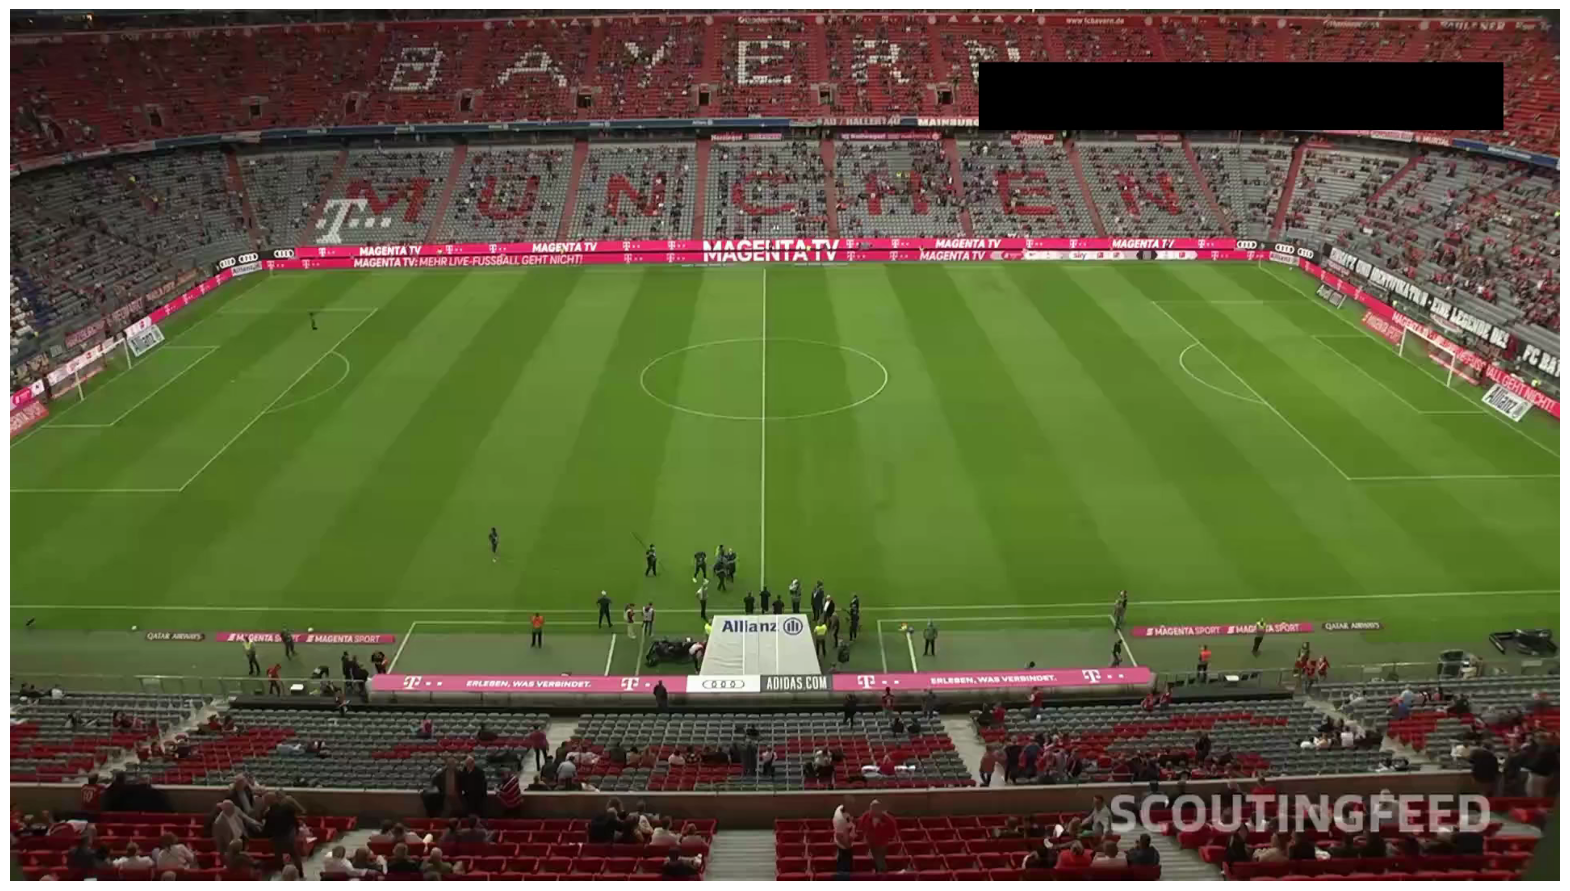

In [30]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show

In [87]:
video_id = '1606b0e6_0'

train = train[train.video_id == video_id]
train[['time','event']].values[:3]

array([[200.2658219228331, 'start'],
       [201.15, 'challenge'],
       [202.7658219228331, 'end']], dtype=object)

In [89]:
train[['time','event']].values[0,1]

'start'

In [ ]:
def extract_training_images(video_id, clip_length):
        os.path.join(dataset_filepath, video_id + '.mp4')
        cap = cv2.VideoCapture(video_path)
        fps = 25
        time_interval = 1/fps
        train = train[train.video_id == video_id]
        print(video_id, df_video.shape)

        #crr_statu => background, play, challenge, throwin
        arr = df_video[['time','event']].values
        for idx in range(len(arr)-1):
            crr_time = arr[idx,0]
            nxt_time = arr[idx+1,0]
            crr_event = arr[idx,1]
            #print(crr_time, nxt_time, crr_event)

            crr_event = crr_event
            if crr_event == 'start':
                crr_status = 'background'
            elif crr_event == 'end':
                # should use as background?
                continue
            else:
                start_or_end, crr_status = crr_event.split('_', 1)
                if start_or_end == 'end':
                    crr_status = 'background'

            result_dir = f"../work/split_images/{split}/{crr_status}"
            if not os.path.exists(result_dir):
                os.makedirs(result_dir, exist_ok=True)

            this_time = crr_time
            while this_time < nxt_time:
                frame_num = int(this_time*fps)

                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
                ret, frame = cap.read()
                out_file = f'{result_dir}/{video_id}_{frame_num:06}.jpg'
                cv2.imwrite(out_file, frame)
                #print(out_file, arr[idx], arr[idx+1], this_time)

                if crr_status == 'background':
                    this_time += time_interval*10
                else:
                    this_time += time_interval

In [ ]:
def create_training_clips():